<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install torch
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_650/491656687.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')                                            
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112247 non-null  int64 
 1   text    112247 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      5375
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Define pretrained tokenizer and model

model_name = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(model_name, 
#                                                               num_labels=2, 
#                                                             output_attentions = False, # Whether the model returns attentions weights.
#                                                             output_hidden_states = False,
#                                                             return_dict=True )
set_seed(100)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data and Fine Tune Transformers</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    
    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    
    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy, 
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
  
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            #eval_steps=500,
            #per_device_train_batch_size=1,
            #per_device_eval_batch_size=1,
            num_train_epochs=epoch, #1 was okay
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
        # model_init=model_init,
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )
            
        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


#####################
# Run Hold Out Test #
#####################

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1127)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [8]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='Electra',
                            model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-3820', 
                            average_method='binary',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(8,5), 
                        cbar=True, 
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection', 
                        cmap='YlGnBu', 
                        sum_stats=False)



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [ ]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.123400,0.151883,0.960891,0.617021,0.485130,0.543184,0.974357,0.984841,0.979571,0.795689,0.734986,0.761378
2,0.131600,0.151560,0.965167,0.765343,0.394052,0.520245,0.970223,0.993918,0.981927,0.867783,0.693985,0.751086
3,0.125300,0.131668,0.964365,0.665865,0.514870,0.580713,0.975853,0.986994,0.981392,0.820859,0.750932,0.781052
4,0.117100,0.145611,0.965256,0.697861,0.485130,0.572368,0.974472,0.989426,0.981892,0.836167,0.737278,0.777130


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-3

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.174100,0.186898,0.960178,0.869919,0.198885,0.323752,0.961178,0.998503,0.979485,0.915548,0.598694,0.651618
2,0.151700,0.155348,0.965880,0.755776,0.425651,0.544590,0.971708,0.993076,0.982276,0.863742,0.709363,0.763433
3,0.138100,0.133266,0.967929,0.757225,0.486989,0.592760,0.974630,0.992140,0.983307,0.865928,0.739564,0.788034
4,0.118800,0.131528,0.967751,0.731579,0.516729,0.605664,0.976026,0.990456,0.983188,0.853802,0.753592,0.794426


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-3

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.117100,0.106589,0.971047,0.795014,0.533457,0.638487,0.976896,0.993076,0.984919,0.885955,0.763266,0.811703
2,0.123200,0.139061,0.969710,0.819355,0.472119,0.599057,0.973981,0.994760,0.984261,0.896668,0.733439,0.791659
3,0.130200,0.106276,0.971136,0.764851,0.574349,0.656051,0.978837,0.991111,0.984936,0.871844,0.782730,0.820493
4,0.094500,0.114428,0.971403,0.752914,0.600372,0.668046,0.980085,0.990081,0.985058,0.866499,0.795227,0.826552


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-3

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.147200,0.127330,0.970067,0.725446,0.604089,0.659229,0.980236,0.988491,0.984346,0.852841,0.796290,0.821788
2,0.190600,0.200579,0.954744,0.875000,0.065056,0.121107,0.955029,0.999532,0.976774,0.915015,0.532294,0.548941
3,0.123100,0.121970,0.972294,0.780247,0.587361,0.670201,0.979482,0.991672,0.985540,0.879865,0.789516,0.827871


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-3

### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the trainin

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884 (score: 0.13166798651218414).


Epoch,Training Loss,Validation Loss


1it [00:25, 25.63s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to save

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-50512 (score: 0.13152843713760376).


Epoch,Training Loss,Validation Loss


2it [00:50, 25.13s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to save

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).


Epoch,Training Loss,Validation Loss


3it [01:14, 24.52s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-37884).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to save

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
4,0.096100,0.108015,0.972739,0.755507,0.637546,0.691532,0.981896,0.989614,0.985740,0.868701,0.813580,0.838636


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512 (score: 0.10801516473293304).
4it [24:52, 574.95s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.127400,0.123260,0.970601,0.776596,0.542751,0.638950,0.977325,0.992140,0.984677,0.876960,0.767445,0.811813
2,0.117300,0.126562,0.968018,0.685300,0.615242,0.648384,0.980730,0.985777,0.983247,0.833015,0.800509,0.815815
3,0.109800,0.116237,0.970958,0.734513,0.617100,0.670707,0.980878,0.988771,0.984809,0.857696,0.802936,0.827758
4,0.102400,0.117204,0.972472,0.770686,0.605948,0.678460,0.980374,0.990924,0.985621,0.875530,0.798436,0.832040


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-3

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 88396
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the traini

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.094000,0.159119,0.964098,0.654462,0.531599,0.586667,0.976641,0.985871,0.981234,0.815551,0.758735,0.783950


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884 (score: 0.13166798651218414).
1it [23:58, 1438.95s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
6,0.106900,0.120732,0.967394,0.716080,0.529740,0.608974,0.976632,0.989426,0.982988,0.846356,0.759583,0.795981
7,0.099800,0.153123,0.968196,0.749311,0.505576,0.603774,0.975511,0.991485,0.983433,0.862411,0.748531,0.793603
8,0.092400,0.136779,0.968374,0.727047,0.544610,0.622742,0.977361,0.989707,0.983495,0.852204,0.767158,0.803119


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.107700,0.125936,0.971492,0.740088,0.624535,0.677419,0.981246,0.988959,0.985087,0.860667,0.806747,0.831253
6,0.106700,0.111305,0.972116,0.775061,0.589219,0.669483,0.979567,0.991391,0.985444,0.877314,0.790305,0.827463
7,0.089400,0.118638,0.971492,0.757075,0.596654,0.667360,0.979909,0.990362,0.985108,0.868492,0.793508,0.826234


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-8

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.102600,0.122468,0.969710,0.701220,0.641264,0.669903,0.982018,0.986245,0.984127,0.841619,0.813754,0.827015
6,0.104700,0.122835,0.972561,0.776442,0.600372,0.677149,0.980109,0.991298,0.985672,0.878276,0.795835,0.831410
7,0.100300,0.109478,0.972294,0.762125,0.613383,0.679712,0.980726,0.990362,0.985521,0.871426,0.801873,0.832616


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-8

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.099500,0.116108,0.970334,0.753086,0.566914,0.646872,0.978466,0.990643,0.984517,0.865776,0.778779,0.815694
6,0.101900,0.111350,0.971492,0.752315,0.604089,0.670103,0.980265,0.989988,0.985102,0.866290,0.797039,0.827603
7,0.097400,0.128478,0.971403,0.757720,0.592937,0.665276,0.979730,0.990456,0.985064,0.868725,0.791696,0.825170
8,0.101700,0.125863,0.971136,0.753555,0.591078,0.662500,0.979635,0.990269,0.984923,0.866595,0.790673,0.823712


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-8

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884 (score: 0.13166798651218414).


Epoch,Training Loss,Validation Loss


1it [00:14, 14.96s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768 (score: 0.12073222547769547).


Epoch,Training Loss,Validation Loss


2it [00:40, 21.18s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.105400,0.124696,0.970780,0.735426,0.609665,0.666667,0.980518,0.988959,0.984720,0.857972,0.799312,0.825693


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).
3it [24:15, 657.60s/it]

Complete for fold 3
Running for Fold:  4


### [Continue] Cross Validation (K = 5)

In [20]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884 (score: 0.13166798651218414).


Epoch,Training Loss,Validation Loss


1it [00:15, 15.45s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768 (score: 0.12073222547769547).


Epoch,Training Loss,Validation Loss


2it [00:44, 23.56s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).


Epoch,Training Loss,Validation Loss


3it [01:08, 23.53s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.091600,0.115200,0.971938,0.748330,0.624535,0.680851,0.981255,0.989426,0.985324,0.864792,0.806981,0.833087


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512 (score: 0.10801516473293304).
4it [24:50, 575.90s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768 (score: 0.11135013401508331).


Epoch,Training Loss,Validation Loss


5it [25:12, 302.60s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.123400,0.151883,0.960891,0.617021,0.485130,0.543184,0.974357,0.984841,0.979571,0.795689,0.734986,0.761378
2,0.131600,0.151560,0.965167,0.765343,0.394052,0.520245,0.970223,0.993918,0.981927,0.867783,0.693985,0.751086
3,0.125300,0.131668,0.964365,0.665865,0.514870,0.580713,0.975853,0.986994,0.981392,0.820859,0.750932,0.781052
4,0.117100,0.145611,0.965256,0.697861,0.485130,0.572368,0.974472,0.989426,0.981892,0.836167,0.737278,0.777130


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-3

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.174100,0.186898,0.960178,0.869919,0.198885,0.323752,0.961178,0.998503,0.979485,0.915548,0.598694,0.651618
2,0.151700,0.155348,0.965880,0.755776,0.425651,0.544590,0.971708,0.993076,0.982276,0.863742,0.709363,0.763433
3,0.138100,0.133266,0.967929,0.757225,0.486989,0.592760,0.974630,0.992140,0.983307,0.865928,0.739564,0.788034
4,0.118800,0.131528,0.967751,0.731579,0.516729,0.605664,0.976026,0.990456,0.983188,0.853802,0.753592,0.794426


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-37884/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-37884/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-5

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).


Epoch,Training Loss,Validation Loss


3it [3:08:19, 3082.13s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512 (score: 0.10801516473293304).


Epoch,Training Loss,Validation Loss


4it [3:08:45, 1875.79s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to sav

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768 (score: 0.11135013401508331).


Epoch,Training Loss,Validation Loss


5it [3:09:09, 2269.81s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=10,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the train

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.104900,0.150274,0.963563,0.641138,0.544610,0.588945,0.977247,0.984654,0.980937,0.809193,0.764632,0.784941
6,0.099900,0.148100,0.965702,0.709589,0.481413,0.573643,0.974309,0.990081,0.982132,0.841949,0.735747,0.777888
7,0.121300,0.149437,0.965345,0.672055,0.540892,0.599382,0.977113,0.986713,0.981889,0.824584,0.763803,0.790636


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-8

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to sa

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.137400,0.122608,0.964187,0.634921,0.594796,0.614203,0.979666,0.982783,0.981222,0.807293,0.788789,0.797713
6,0.106800,0.137765,0.966592,0.700246,0.529740,0.603175,0.976613,0.988584,0.982562,0.838429,0.759162,0.792868
7,0.106000,0.156640,0.966771,0.721180,0.500000,0.590560,0.975212,0.990269,0.982683,0.848196,0.745134,0.786621
8,0.108300,0.140066,0.963029,0.617143,0.602230,0.609595,0.980000,0.981192,0.980596,0.798571,0.791711,0.795096


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-8

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.102900,0.133032,0.970780,0.737557,0.605948,0.665306,0.980339,0.989146,0.984723,0.858948,0.797547,0.825014


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-113652/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=10,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 88396
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the train

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.089100,0.148709,0.963563,0.638116,0.553903,0.593035,0.977691,0.984186,0.980928,0.807903,0.769045,0.786981
9,0.110400,0.164221,0.965612,0.698953,0.496283,0.580435,0.975007,0.989239,0.982072,0.836980,0.742761,0.781253
10,0.087400,0.164408,0.964454,0.657596,0.539033,0.592441,0.977003,0.985871,0.981417,0.817300,0.762452,0.786929


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-101024/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-113652/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-126280
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/check

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.093400,0.145818,0.965345,0.675294,0.533457,0.596054,0.976759,0.987087,0.981896,0.826027,0.760272,0.788975
10,0.085800,0.148618,0.965791,0.694444,0.511152,0.588865,0.975713,0.988678,0.982153,0.835079,0.749915,0.785509


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-113652/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-126280
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-126280/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-126280/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140 (score: 0.1226084902882576).
2it [3:08:31, 5457.09s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).


Epoch,Training Loss,Validation Loss


3it [3:09:05, 2981.02s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.104100,0.120614,0.972027,0.758065,0.611524,0.676955,0.980632,0.990175,0.985380,0.869348,0.800850,0.831168
10,0.095200,0.121592,0.972205,0.760369,0.613383,0.679012,0.980725,0.990269,0.985474,0.870547,0.801826,0.832243


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-113652/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-126280
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-126280/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-126280/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512 (score: 0.10801516473293304).
4it [4:24:30, 3590.39s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126280
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.083400,0.137194,0.972027,0.775862,0.585502,0.667373,0.979388,0.991485,0.985399,0.877625,0.788493,0.826386
10,0.097900,0.126289,0.971581,0.752887,0.605948,0.671473,0.980356,0.989988,0.985148,0.866621,0.797968,0.828310


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-113652/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-126280
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-126280/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-126280/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768 (score: 0.11135013401508331).
5it [5:42:16, 4107.29s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='Electra',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=11,
                         checkpoint=True)

Developing Model with Cross validation for: Electra


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 11
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138908
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 126280
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
11,0.093600,0.163852,0.964811,0.669834,0.524164,0.588113,0.976305,0.986994,0.981620,0.823069,0.755579,0.784866


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-138908
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-138908/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-138908/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold1/checkpoint-37884 (score: 0.13166798651218414).
1it [23:32, 1412.30s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 11
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138908
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
11,0.082300,0.151789,0.965702,0.698701,0.500000,0.582882,0.975185,0.989146,0.982115,0.836943,0.744573,0.782499


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-138908
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-138908/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-138908/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold2/checkpoint-63140 (score: 0.1226084902882576).
2it [47:10, 1415.91s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 11
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138908
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
11,0.086100,0.130388,0.971225,0.749420,0.600372,0.666667,0.980082,0.989894,0.984963,0.864751,0.795133,0.825815


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-138908
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-138908/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-138908/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold3/checkpoint-37884 (score: 0.10627561807632446).
3it [1:10:43, 1414.46s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 11
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138908
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
11,0.092800,0.121549,0.971849,0.756944,0.607807,0.674227,0.980450,0.990175,0.985289,0.868697,0.798991,0.829758


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-138908
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-138908/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-138908/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold4/checkpoint-50512 (score: 0.10801516473293304).
4it [1:34:14, 1413.27s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-126280).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 11
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138908
  Continuing training from checkpoint, will skip to s

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
11,0.087700,0.125111,0.971938,0.747228,0.626394,0.681496,0.981344,0.989333,0.985322,0.864286,0.807863,0.833409


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-138908
Configuration saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-138908/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-138908/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_Electra/fold5/checkpoint-75768 (score: 0.11135013401508331).
5it [1:57:48, 1413.61s/it]

Complete for fold 5


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Hold Out Split</h2>
</div>

In [9]:
run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

Developing Model with Hold Out Splits for: Electra


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.138700,0.140726,0.959822,0.597753,0.494424,0.541200,0.974768,0.983251,0.978991,0.786260,0.738837,0.760096
2,0.150500,0.152378,0.958218,0.570265,0.520446,0.544218,0.975964,0.980256,0.978106,0.773114,0.750351,0.761162
3,0.142800,0.145807,0.962494,0.640964,0.494424,0.558237,0.974838,0.986058,0.980416,0.807901,0.740241,0.769327
4,0.126800,0.134956,0.960713,0.602105,0.531599,0.564659,0.976558,0.982315,0.979428,0.789332,0.756957,0.772044
5,0.104100,0.148582,0.963207,0.655087,0.490706,0.561105,0.974681,0.986994,0.980799,0.814884,0.738850,0.770952
6,0.105700,0.158221,0.966058,0.737160,0.453532,0.561565,0.973013,0.991859,0.982346,0.855086,0.722695,0.771955
7,0.117800,0.153189,0.965167,0.681481,0.513011,0.585366,0.975786,0.987929,0.981820,0.828634,0.750470,0.783593
8,0.080400,0.153648,0.965256,0.680488,0.518587,0.588608,0.976052,0.987742,0.981862,0.828270,0.753165,0.785235


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/outpu

Complete for hold-out validate set


In [ ]:
run_hold_out_split(model_name='Electra',
                       epoch=12,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Developing Model with Hold Out Splits for: Electra


Loading model from content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 12
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 151536
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
9,0.117900,0.153162,0.964722,0.682051,0.494424,0.573276,0.974896,0.988397,0.981600,0.828474,0.741410,0.777438
10,0.092600,0.166043,0.965167,0.689922,0.496283,0.577297,0.974995,0.988771,0.981835,0.832459,0.742527,0.779566
11,0.099300,0.168965,0.964633,0.674074,0.507435,0.579003,0.975508,0.987649,0.981541,0.824791,0.747542,0.780272


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-113652
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-113652/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-113652/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-126280
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-126280/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-126280/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout_1/checkpoint-138908
Configuration saved in content/drive/MyDrive_binar

In [13]:
#holdout1best
run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024


Developing Model with Hold Out Splits for: Electra


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.120900,0.143816,0.960535,0.605322,0.507435,0.552073,0.975404,0.983344,0.979358,0.790363,0.745390,0.765715
2,0.135100,0.149520,0.965702,0.770318,0.405204,0.531060,0.970755,0.993918,0.982200,0.870536,0.699561,0.756630
3,0.125600,0.144958,0.965969,0.763514,0.420074,0.541966,0.971452,0.993450,0.982328,0.867483,0.706762,0.762147
4,0.114500,0.127900,0.964276,0.659674,0.526022,0.585315,0.976380,0.986339,0.981334,0.818027,0.756180,0.783325
5,0.099000,0.144239,0.966325,0.732558,0.468401,0.571429,0.973716,0.991391,0.982474,0.853137,0.729896,0.776951


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_Elect

KeyboardInterrupt: 

In [15]:
#holdout1best
run_hold_out_split(model_name='Electra',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-63140).


Developing Model with Hold Out Splits for: Electra


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 63140
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
6,0.096100,0.165210,0.966949,0.744868,0.472119,0.577929,0.973907,0.991859,0.982801,0.859387,0.731989,0.780365
7,0.109500,0.160267,0.965078,0.676329,0.520446,0.588235,0.976135,0.987461,0.981766,0.826232,0.753954,0.785001
8,0.085800,0.166399,0.965612,0.683575,0.526022,0.594538,0.976413,0.987742,0.982045,0.829994,0.756882,0.788291


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_Electra/holdout1/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_Elec

Complete for hold-out validate set


### Test Split Cross Validation

#### Epoch 1

***** Running Prediction *****
  Num examples = 11225
  Batch size = 8


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10687
           1       0.60      0.49      0.54       538

    accuracy                           0.96     11225
   macro avg       0.79      0.74      0.76     11225
weighted avg       0.96      0.96      0.96     11225


Label 1: Cyberbullying
Precision:  0.597752808988764
Recall:  0.4944237918215613
F-measure:  0.5412004069175993

Label 0: Non-Cyberbullying
Precision:  0.9747680890538033
Recall:  0.9832506783943108
F-measure:  0.978991009456375

Macro Metrics
Precision:  0.7862604490212837
Recall:  0.7388372351079361
F-measure:  0.7600957081869871



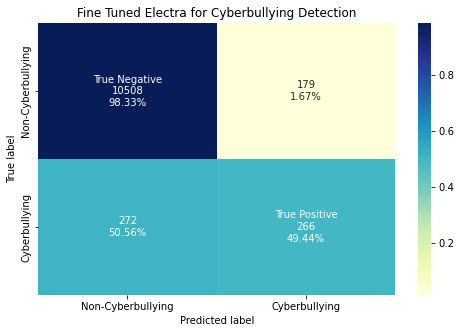

In [9]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-12628', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-25256/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-25256",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10687
           1       0.57      0.52      0.54       538

    accuracy                           0.96     11225
   macro avg       0.77      0.75      0.76     11225
weighted avg       0.96      0.96      0.96     11225


Label 1: Cyberbullying
Precision:  0.570264765784114
Recall:  0.5204460966542751
F-measure:  0.5442176870748298

Label 0: Non-Cyberbullying
Precision:  0.975964225824483
Recall:  0.9802563862636848
F-measure:  0.97810559731105

Macro Metrics
Precision:  0.7731144958042985
Recall:  0.7503512414589799
F-measure:  0.7611616421929399



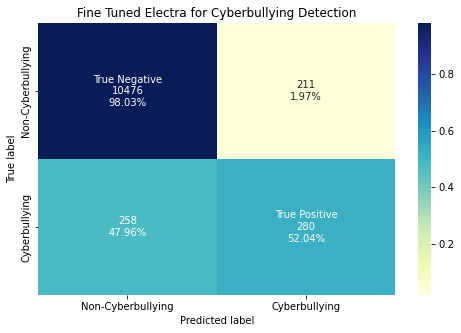

In [10]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-25256', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-37884/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-37884",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10687
           1       0.64      0.49      0.56       538

    accuracy                           0.96     11225
   macro avg       0.81      0.74      0.77     11225
weighted avg       0.96      0.96      0.96     11225


Label 1: Cyberbullying
Precision:  0.6409638554216868
Recall:  0.4944237918215613
F-measure:  0.5582371458551941

Label 0: Non-Cyberbullying
Precision:  0.9748381128584643
Recall:  0.9860578272667727
F-measure:  0.980415871982137

Macro Metrics
Precision:  0.8079009841400755
Recall:  0.740240809544167
F-measure:  0.7693265089186656



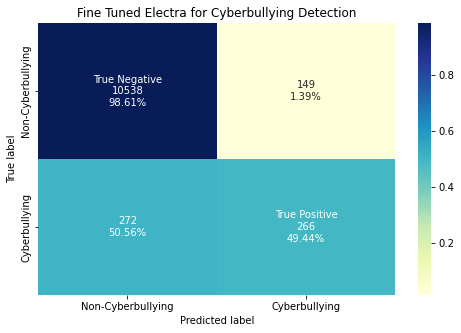

In [11]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-37884', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-50512/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-50512",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10687
           1       0.60      0.53      0.56       538

    accuracy                           0.96     11225
   macro avg       0.79      0.76      0.77     11225
weighted avg       0.96      0.96      0.96     11225


Label 1: Cyberbullying
Precision:  0.6021052631578947
Recall:  0.5315985130111525
F-measure:  0.5646594274432379

Label 0: Non-Cyberbullying
Precision:  0.9765581395348837
Recall:  0.9823149621034902
F-measure:  0.9794280916172972

Macro Metrics
Precision:  0.7893317013463892
Recall:  0.7569567375573214
F-measure:  0.7720437595302676



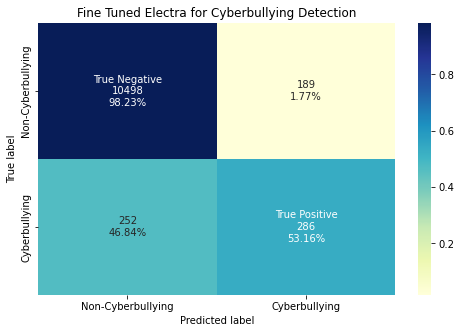

In [12]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-50512', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-63140/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-63140",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10687
           1       0.66      0.49      0.56       538

    accuracy                           0.96     11225
   macro avg       0.81      0.74      0.77     11225
weighted avg       0.96      0.96      0.96     11225


Label 1: Cyberbullying
Precision:  0.6550868486352357
Recall:  0.49070631970260226
F-measure:  0.5611052072263549

Label 0: Non-Cyberbullying
Precision:  0.9746812049528738
Recall:  0.9869935435575934
F-measure:  0.9807987354130828

Macro Metrics
Precision:  0.8148840267940547
Recall:  0.7388499316300978
F-measure:  0.7709519713197188



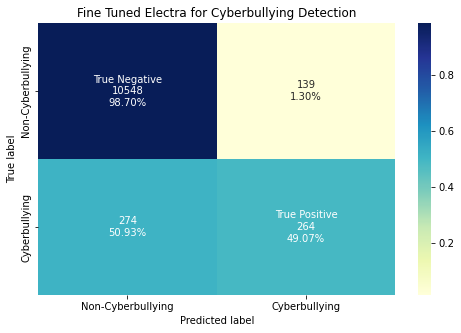

In [13]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-63140', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-75768/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-75768",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10687
           1       0.74      0.45      0.56       538

    accuracy                           0.97     11225
   macro avg       0.86      0.72      0.77     11225
weighted avg       0.96      0.97      0.96     11225


Label 1: Cyberbullying
Precision:  0.7371601208459214
Recall:  0.45353159851301117
F-measure:  0.5615650172612198

Label 0: Non-Cyberbullying
Precision:  0.9730126675234074
Recall:  0.9918592682698606
F-measure:  0.9823455817617349

Macro Metrics
Precision:  0.8550863941846645
Recall:  0.7226954333914359
F-measure:  0.7719552995114773



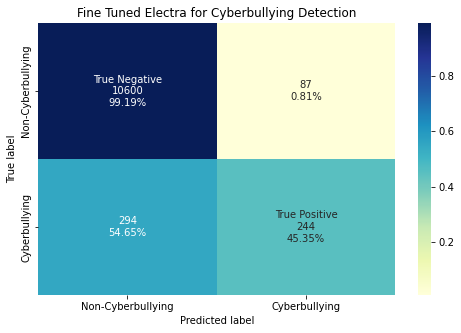

In [14]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-75768', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-88396/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-88396",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.68      0.51      0.59       538

    accuracy                           0.97     11225
   macro avg       0.83      0.75      0.78     11225
weighted avg       0.96      0.97      0.96     11225


Label 1: Cyberbullying
Precision:  0.6814814814814815
Recall:  0.5130111524163569
F-measure:  0.5853658536585366

Label 0: Non-Cyberbullying
Precision:  0.9757855822550832
Recall:  0.987929259848414
F-measure:  0.9818198725996187

Macro Metrics
Precision:  0.8286335318682823
Recall:  0.7504702061323854
F-measure:  0.7835928631290776



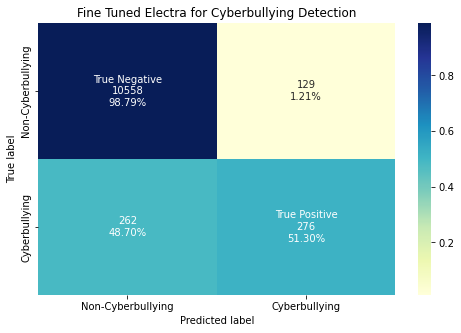

In [15]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-88396', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-101024/config.json
Model config ElectraConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-101024",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": tr

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.68      0.52      0.59       538

    accuracy                           0.97     11225
   macro avg       0.83      0.75      0.79     11225
weighted avg       0.96      0.97      0.96     11225


Label 1: Cyberbullying
Precision:  0.6804878048780488
Recall:  0.5185873605947955
F-measure:  0.5886075949367088

Label 0: Non-Cyberbullying
Precision:  0.976051779935275
Recall:  0.9877421165902498
F-measure:  0.9818621523579202

Macro Metrics
Precision:  0.828269792406662
Recall:  0.7531647385925226
F-measure:  0.7852348736473145



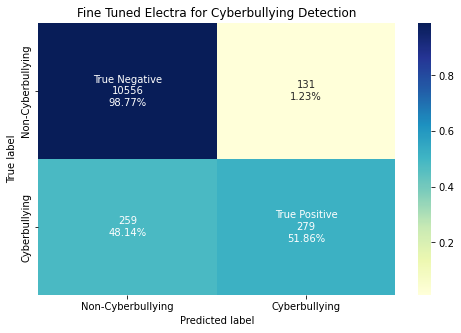

In [16]:
compute_metrics_holdout(model_name='Electra',
                        model_path='content/drive/MyDrive_binary/output_Electra/holdout/checkpoint-101024', 
                        average_method='binary',
                        X_test=X_test)